Example based on the tutorial at this <a href="https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118">link</a>

In [27]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
torch.set_printoptions(precision=4, sci_mode=False)

In [2]:
# MNIST dataset 
train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=transforms.ToTensor(),  
                               download=True)

test_dataset = datasets.MNIST(root='./data', 
                              train=False, 
                              transform=transforms.ToTensor())

# Data loader
# - It's faster to train the model in batches instead of one at a time.
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=64, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=64, 
                         shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 894109.74it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 45396.94it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 246555.68it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2236765.15it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# Checking the dataset length
print("Length of train dataset: ", len(train_dataset))
print("Length of test dataset: ", len(test_dataset))

Length of train dataset:  60000
Length of test dataset:  10000


label: 6
image.shape: torch.Size([1, 28, 28])


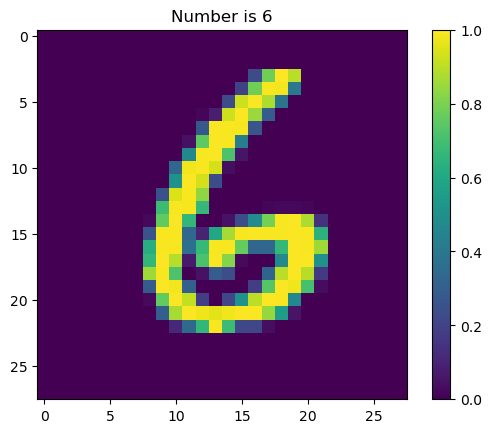

In [4]:
x_image, y_label = train_dataset[6000]
print("label:", y_label)
print("image.shape:", x_image.shape)

def display_image(image, label):
    plt.imshow( image.permute(1, 2, 0) )
    plt.title(f'Number is {label}')
    plt.colorbar()
    plt.show()

display_image(x_image, y_label)

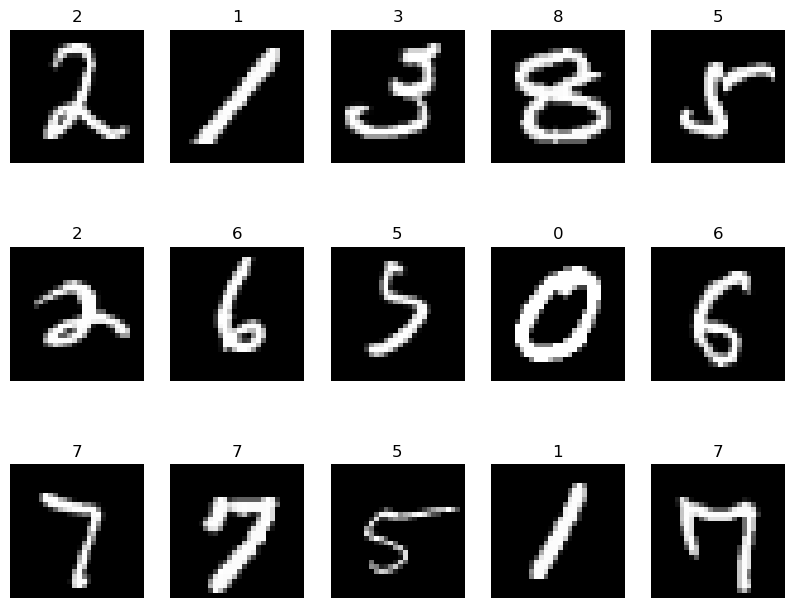

In [6]:
# Displaying multiple images from the dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [29]:
"""
 in_channels=1: because our input is a grayscale image.
 Stride: is the number of pixels to pass at a time when sliding the convolutional kernel.
 kernel_size: we need to define a kernel which is a small matrix of size 3 * 3. 
  To perform the convolution operation, we just need to slide the kernel along the 
  image horizontally and vertically and do the dot product of the kernel and 
  the small portion of the image.
"""
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolutional Layers (2D) - 2D because we're dealing with images (3D would be video)
    # 1 input channel, 6 output channels, 3x3 kernal size
    self.conv1 = nn.Conv2d(in_channels=1,              
                           out_channels=6,            
                           kernel_size=3,              
                           stride=1)
    # 6 input channels, 16 output channels, 3x3 kernal size
    self.conv2 = nn.Conv2d(in_channels=6,              
                           out_channels=16,            
                           kernel_size=3,              
                           stride=1)
    # Fully Connected Layer
    # 5x5 image dimension, 16 is the output channels from the previous layer
    # 120 output features
    # Why 5x5? Because we've done 2 pooling layers that have reduced the image size
    # 2x2 pooling layer reduces the image size by half
    self.fc1 = nn.Linear(5*5*16, 120)
    # 120 input features, 84 output features
    self.fc2 = nn.Linear(120, 84)
    # 84 input features, 10 output features
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    # Pass through the first convolutional layer
    # Pass through the relu activation function
    out = torch.relu(self.conv1(X))
    # Pass through the pooling layer
    # 2x2 kernal and stride 2
    out = torch.max_pool2d(out,2,2) # 2x2 kernal and stride 2
    # Second Pass
    # Pass through the second convolutional layer
    # Pass through the relu activation function
    out = torch.relu(self.conv2(out))
    # Pass through the pooling layer
    # 2x2 kernal and stride 2
    out = torch.max_pool2d(out,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    # -1 is a placeholder for the batch size
    # 16 is the number of output channels from the previous layer
    # 5x5 is the image size
    # Why 5x5? Because we've done 2 pooling layers that have reduced the image size
    # We need to flatten it out to pass it through the fully connected layers
    out = out.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    out = torch.relu(self.fc1(out))
    out = torch.relu(self.fc2(out))
    out = self.fc3(out)
    return torch.softmax(out, dim=1)

In [30]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
# Loss Function Optimizer
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Train the model
n_total_steps = len(train_loader)
num_epochs = 3

In [32]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Forward pass
        outputs = model(images)
        loss = lossfun(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/3], Step [100/938], Loss: 1.7717
Epoch [1/3], Step [200/938], Loss: 1.8100
Epoch [1/3], Step [300/938], Loss: 1.7421
Epoch [1/3], Step [400/938], Loss: 1.6952
Epoch [1/3], Step [500/938], Loss: 1.7890
Epoch [1/3], Step [600/938], Loss: 1.6798
Epoch [1/3], Step [700/938], Loss: 1.5416
Epoch [1/3], Step [800/938], Loss: 1.5615
Epoch [1/3], Step [900/938], Loss: 1.5531
Epoch [2/3], Step [100/938], Loss: 1.4839
Epoch [2/3], Step [200/938], Loss: 1.5263
Epoch [2/3], Step [300/938], Loss: 1.5122
Epoch [2/3], Step [400/938], Loss: 1.4849
Epoch [2/3], Step [500/938], Loss: 1.5052
Epoch [2/3], Step [600/938], Loss: 1.5697
Epoch [2/3], Step [700/938], Loss: 1.4972
Epoch [2/3], Step [800/938], Loss: 1.4616
Epoch [2/3], Step [900/938], Loss: 1.5137
Epoch [3/3], Step [100/938], Loss: 1.4775
Epoch [3/3], Step [200/938], Loss: 1.4813
Epoch [3/3], Step [300/938], Loss: 1.4923
Epoch [3/3], Step [400/938], Loss: 1.4690
Epoch [3/3], Step [500/938], Loss: 1.4747
Epoch [3/3], Step [600/938], Loss:

label 7
image.shape torch.Size([1, 28, 28])


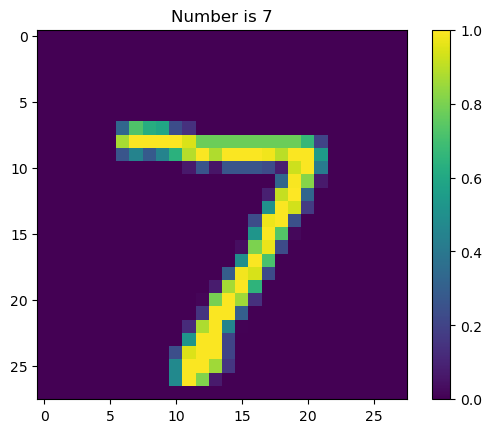

In [33]:
x_sample = test_dataset[0]
x_image, y_label = x_sample
print("label", y_label)
print("image.shape", x_image.shape)
display_image(x_image, y_label)

In [34]:
# Use the trained model to predict the label of this image
yhat_sample = model(x_image)
yhat_sample

tensor([[    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     1.0000,     0.0000,     0.0000]],
       grad_fn=<SoftmaxBackward0>)

In [36]:
# Get the predicted digit using the index of the maximum value
index = torch.argmax(yhat_sample)
predicted_digit = index.item()
print("Predicted digit:", predicted_digit)

Predicted digit: 7


In [37]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = model(images)

        # value: actual number, index: predicted number
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        #display_image(images[0].reshape(1, 28, 28), predicted[0])

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the NN on the {len(test_dataset)} test images: {acc} %')

Accuracy of the NN on the 10000 test images: 97.58 %
